Classification metrics are performance evaluation measures used to assess how well a classification model (such as logistic regression, decision trees, or support vector machines) is predicting categorical outcomes (labels). These metrics are especially useful in binary and multi-class classification tasks to quantify the model's ability to predict the correct class labels.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

Here we'll apply our knowledge about classification metrics to a fraud detection dataset. In order to present some of the aspects described here, I'll develop a very simple solution based on a XGBoost classifier with no previous feature engineering, or parameter tunning.

In [2]:
df = pd.read_csv("creditcard.csv")
df.drop(columns=["Time"], inplace=True)

As we can see below, we are dealing with a very skewed positive class. This makes sense because credit card frauds are the exception to the rule. The choice of an anomaly detection problem was intentional since we can highlight some flaws and strengths from each metric.

In [3]:
(df.Class.value_counts(normalize=True)*100).rename("Classes' Proportions").to_frame()

,Classes' Proportions
Class,
0,99.827251
1,0.172749


We've chosen to use a simple cross-validation approach.

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(df.drop(columns=["Class"]), df.Class)

Now let's check whether the positive class proportions are similar in both sets, that is, the train/test split was indeed stratified

In [5]:
print(
    f"The positive class proportion in train set is {(Y_train == 1).sum() / Y_train.shape[0]:0.3f} \
whereas in test set is {(Y_test == 1).sum() / Y_test.shape[0]:.3f}"
)

The positive class proportion in train set is 0.002 whereas in test set is 0.001


Since the sets' proportions are roughly the same, let's train our model and perform the predictions

In [6]:

xgb = XGBClassifier()
xgb.fit(X_train, Y_train)

preds = xgb.predict(X_test)
pred_probas = xgb.predict_proba(X_test)


---
## **Confusion Matrix**

The major aspect that differentiates a supervised learning algorithm to the remaining ones is the data used in the training process. Basically, the inputs are (x,y) tuples which correspond to the features, and the class to what the record belongs to, respectively. Consequently, a prediction ŷ can easily be assessed by comparing the equivalence of y and ŷ. From this comparison we can derive four different status:

- **True Positive:** when the original, and the predicted label both belong to the positive class.
- **False Positive:** when the original label belongs to the negative class, whereas the predicted label belongs to the positive.
- **True Negative:** when the original, and the predicted label both belong to the negative class.
- **False Negative:** when the original label belongs to the positive class, whereas the predicted label belongs to the negative.

These four states are the basis of almost all supervised learning metrics. We begin with the Confusion Matrix, a simple, yet powerful means to visualize the performance of a given model by simply counting the frequency from each of the status above.

- **Confusion Matrix:** Essentially, a confusion matrix builds a table in which the lines represent the predicted values, whereas the columns represent the true labels. Since with this metric we can visualize every possible outcome for the prediction, we have a general understanding of the whole scenario, and have a rough estimation for the model performance.

In [7]:
c = confusion_matrix(Y_test, preds) / Y_test.shape[0] * 100
c = np.round(c, 2)

pd.DataFrame(
    c,
    columns=["Predicted Negative", "Predicted Positive"],
    index=["Negative Label", "Positive Label"]
)

,Predicted Negative,Predicted Positive
Negative Label,99.85,0.00
Positive Label,0.03,0.11


As we can see above, the confusion matrix allows us to easily spot where the main misclassification errors lie. For example, since we are focusing mostly on positive class items, we need to try reduce the False Negatives ($C_{0,0}$ cell) from our model. Maybe at the cost of a higher False Positive rate.

## **Precision Score**

In order to introduce our next classification metric, let’s go through a quick example. Imagine you’re a doctor who applies machine learning models to predict if a patient must resort to a surgical procedure as a treatment for a given disease. We must have in mind that surgical interventions must be avoided as much as possible and, hence, you don’t want your machine learning models to make frivolous recommendations, i.e. False Positives. In such scenarios, the models should have high Precisions. 

- **Precision:** The precision metric expresses the percentage of predictions that were indeed positive.

\begin{equation}
\frac{tp}{tp+fp}
\end{equation}

In [8]:
print(f"The Precision score was {precision_score(Y_test, preds):.2f}")

The Precision score was 0.96


Precision seems to be able to capture some of the imperfections on the model's predictions. However, it pays attention to the False Positive rate, a not so much important concept for the anomaly detection problem (even less important when the checking procedure is relatively cheap). Consequently, the final score still points to a considerably good solution.

---

## **Recall Score**

The Recall, also known as Sensitivity, is a metric concerned with the True Positive Rate. For example, when dealing with fraud detection, it might be cheaper to investigate many suspicious cases - even if they’re false alarms - than to let one single example go by inadvertently. Hence, in such a case we should look for High Sensitivity scores.

- **Recall (Sensitivity):** From all positive records, what percentage was actually predicted as positives?

\begin{equation}
\frac{tp}{tp+fn}
\end{equation}

In [9]:
print(f"The Recall score was {recall_score(Y_test, preds):.2f}")

The Recall score was 0.78


As well as Confusion Matrix, Recall seems to have been able to identify the main flaw in our classification model, i.e. its False Negative rate. Hence, in this regard, the model doesn't seem to be so powerful as pictured by the previous alternatives.

## **Area Under the Curve (AUC)**

The Receiver Operating Characteristic (ROC) curve, is a 2-dimensional plot that presents the model prediction ability at every classification threshold. Each point in the visualization has coordinates True Positive Rate (a.k.a. Recall), and False Positive Rate (a.k.a. **1-specificity**), derived from the model built with the respective thresholds. Intuitively, TPR tells us how good the model is in classifying positive records, whereas Specificity tells how good it is to classify negative points. Consequently, if the solution presents a TPR equal to 1 and a FPR equal to 0 (i.e perfect Specificity), we would have developed an oracle model (see the figure below). 

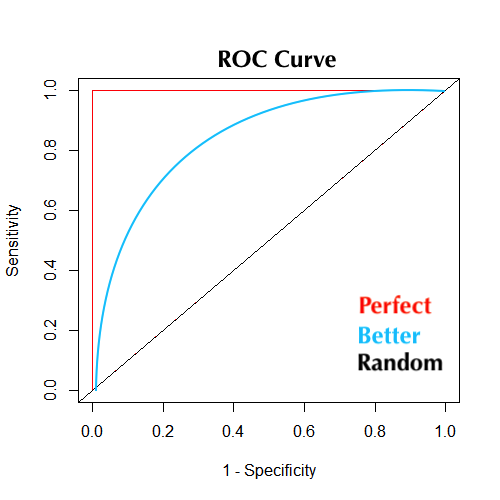

Since the ROC curve displays the general performance of the model, it follows that the bigger the area under the resulting plot, the better will be the average performance of the model. If we normalize the Y-axis’ values, we will end up finding a figure with area ranging in the interval [0, 1]. The Area Under the ROC Curve (AUC) is a classification metric that succinctly expresses the probability that a classifier will give bigger importances to positive instances than to negative ones. A latent problem, however, is that the metric doesn’t express the model’s confidence level, only its correctness rate.

- **AUC:** The probability of giving more importance to positive records if compared to the negative ones.

In [10]:
print(f"The AUC score was {roc_auc_score(Y_test.values, pred_probas[:, 1]):.2f}")

The AUC score was 0.97


---

## **Kolmogorov-Smirnov (KS) Statistic**

Almost every interesting dataset we find in real-world scenarios is composed of n-dimensional random vectors, where each of their dimensions is a random variable that can (or cannot) be related to the other dimensions. G(X) is an oracle function capable of predicting an interest variable (our target) given the observation of each random vector. Essentially, when developing machine learning models, what we’re looking for is a function F capable of imitating G’s predicting behavior. Since G and F are functions over random variables, they can also be seen as random variables which follow an unknown distribution and present Cumulative Distribution Functions (CDF). Intuitively, we can think that if both CDFs are similar, the approximation of G through F is reliable. This measuring can be done with the aid of Two-Sample Kolmogorov-Smirnov’s test.
Add an image

- **Kolmogorov-Smirnov Test:** Measure the quality of the prediction as the distance between the CDFs from the oracle function and the approximation function.

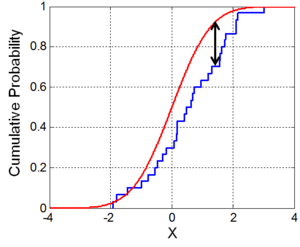

In [11]:
# Get only the probability of being the positive class
pred_probas = pred_probas[:, 1]

print(f"The KS score was {ks_2samp(pred_probas[Y_test == 0], pred_probas[Y_test == 1])[0]:.2f}")

The KS score was 0.89


As we saw above, the differentiation between the classes is quite significant. In other words, the function that generates the positive class items, is substantially different than the one that generates the negative class.